In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/housing-price-prediction-data/housing_price_dataset.csv


In [2]:
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [3]:
df=pd.read_csv("/kaggle/input/housing-price-prediction-data/housing_price_dataset.csv")
df.head()

,SquareFeet,Bedrooms,Bathrooms,Neighborhood,YearBuilt,Price
0,2126,4,1,Rural,1969,215355.283618
1,2459,3,2,Rural,1980,195014.221626
2,1860,2,1,Suburb,1970,306891.012076
3,2294,2,1,Urban,1996,206786.787153
4,2130,5,2,Suburb,2001,272436.239065


In [4]:
print(df.describe())

         SquareFeet      Bedrooms     Bathrooms     YearBuilt          Price
count  50000.000000  50000.000000  50000.000000  50000.000000   50000.000000
mean    2006.374680      3.498700      1.995420   1985.404420  224827.325151
std      575.513241      1.116326      0.815851     20.719377   76141.842966
min     1000.000000      2.000000      1.000000   1950.000000  -36588.165397
25%     1513.000000      3.000000      1.000000   1967.000000  169955.860225
50%     2007.000000      3.000000      2.000000   1985.000000  225052.141166
75%     2506.000000      4.000000      3.000000   2003.000000  279373.630052
max     2999.000000      5.000000      3.000000   2021.000000  492195.259972


In [5]:
#Preprocessing 
#One-hot encode categorial 'Neighborhood' column
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(), ['Neighborhood'])],
    remainder='passthrough'
)


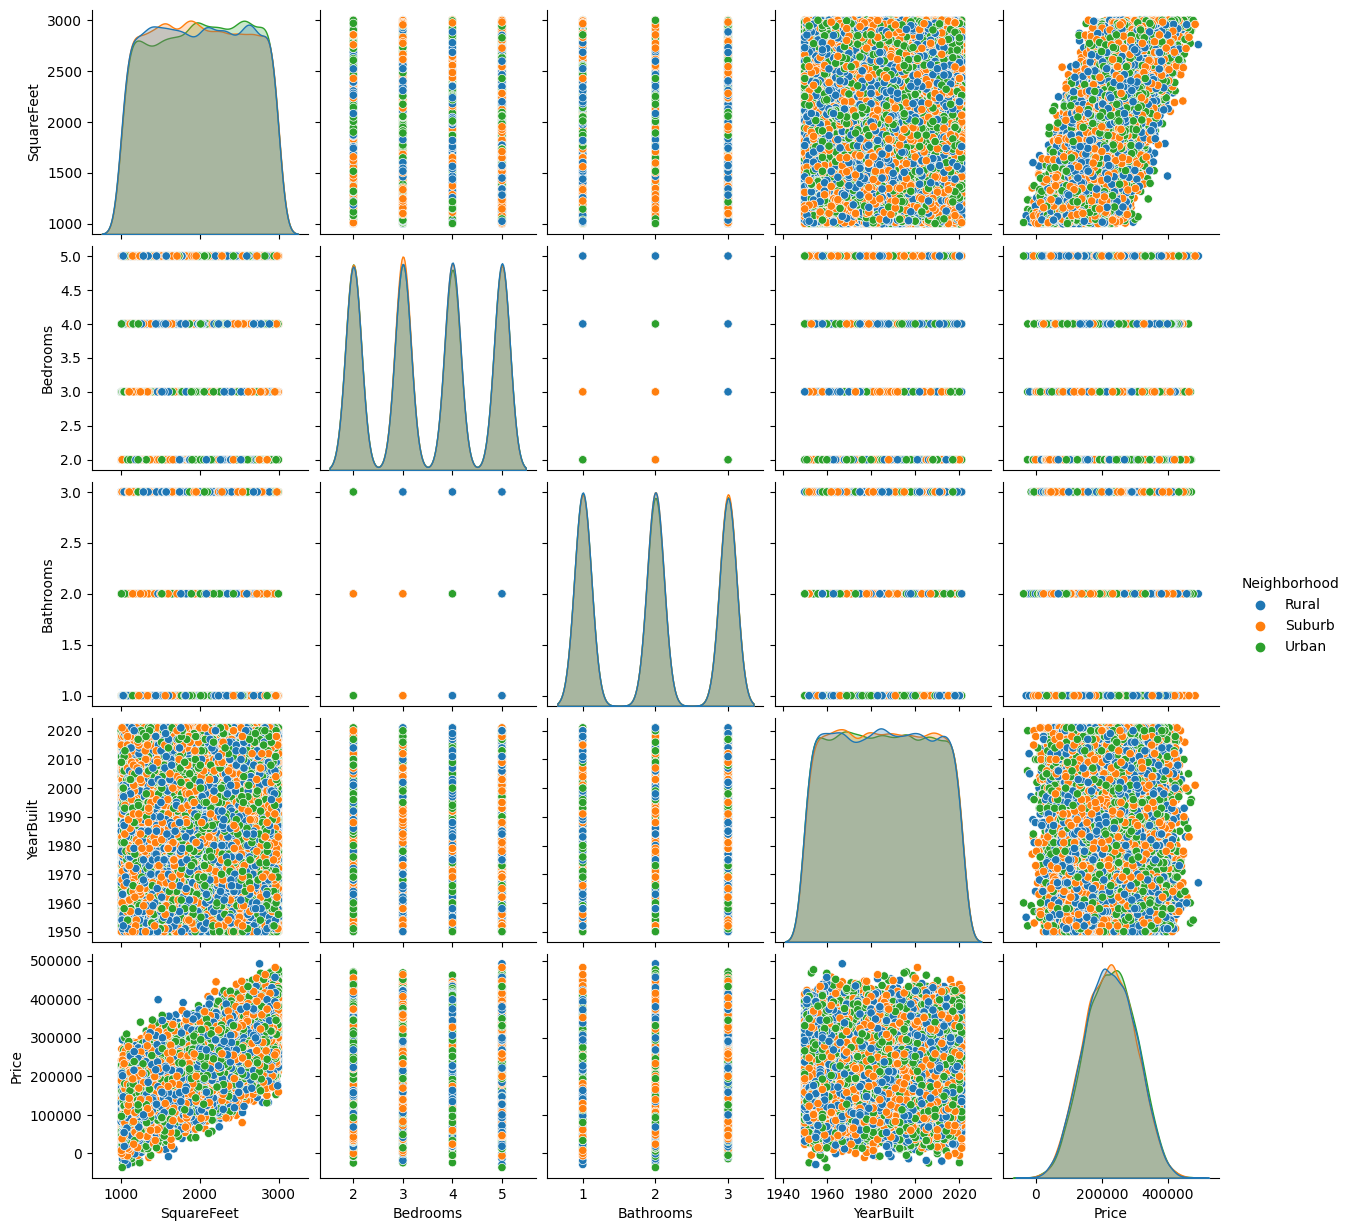

In [6]:
sns.pairplot(df, hue='Neighborhood')  # Pairplot with 'Neighborhood' as hue
plt.show()

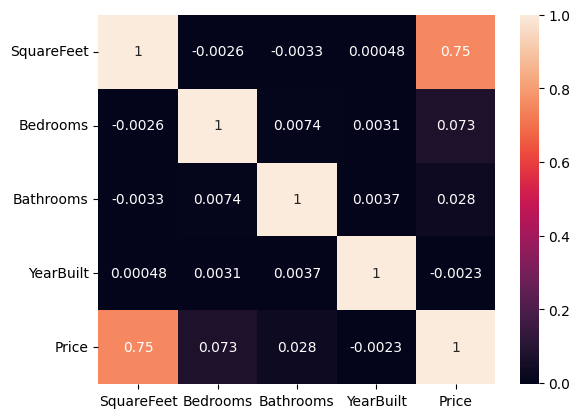

In [7]:
# Drop the 'Neighborhood' column before correlation analysis
numerical_df = df.drop('Neighborhood', axis=1)
correlation_matrix = numerical_df.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()


Model: Linear Regression
Cross-validation Mean MSE: 2506093728.7176323
Test MSE: 2436249371.3072467
Test R-squared: 0.5755628630306235


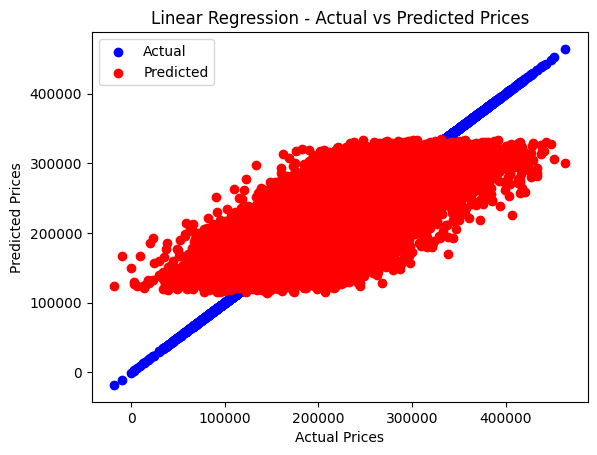

Model: Random Forest
Cross-validation Mean MSE: 2824631804.65457
Test MSE: 2748392430.993315
Test R-squared: 0.5211820971950937


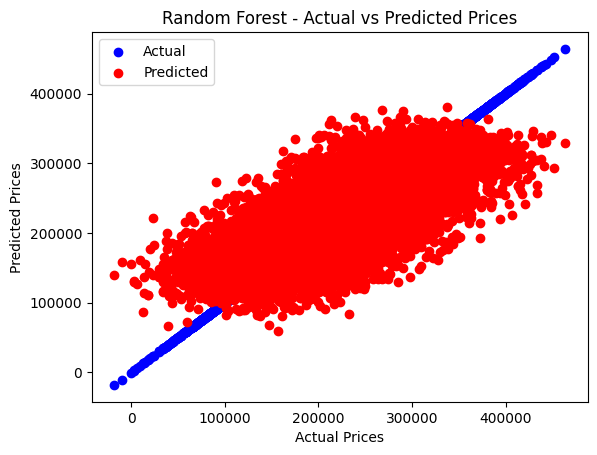

In [8]:
# Define models
models = [
    ('Linear Regression', LinearRegression()),
    ('Random Forest', RandomForestRegressor())
]

# Model Building and Evaluation
for name, model in models:
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Prepare data
    X = df.drop('Price', axis=1)
    y = df['Price']
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_results = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    cv_results = -cv_results  # Convert negatives to positives for MSE
    
    # Print results
    print(f"Model: {name}")
    print(f"Cross-validation Mean MSE: {cv_results.mean()}")
    
    # Fit model on full training set
    pipeline.fit(X_train, y_train)
    
    # Predictions on test set
    y_pred = pipeline.predict(X_test)
    
    # Evaluation
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Print test set results
    print(f"Test MSE: {mse}")
    print(f"Test R-squared: {r2}")
    
    # Plot predictions vs actual values
    plt.scatter(y_test, y_test, color='blue', label='Actual')
    plt.scatter(y_test, y_pred, color='red', label='Predicted')
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    
    plt.title(f"{name} - Actual vs Predicted Prices")
    plt.legend()
    plt.show()
